In [1]:
library(tidyverse)
library(grid)
library(gridExtra)

source("../../evaluation_utils/plots_eda.R")
source("../../evaluation_utils/filtering.R")

Warning message:
“package ‘tidyverse’ was built under R version 4.2.2”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.2”
Warning message:
“package ‘readr’ was built under R version 4.2.2”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.2”
Warning message:
“package ‘lubridate’ was built under R version 4.2.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────────

## Best studies:
- PRJEB27928 (GERMANY)
- PRJEB6070  (FRANCE)
- PRJNA429097 (CHINA)
- PRJEB10878 (CHINA)

5th - PRJNA731589 (CHINA)

# Load data

In [2]:
metadata <- read.csv('/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/raw/metadata_2250_CRC_cohort_20231114.tsv', sep = '\t') %>%
    filter(is.na(to_exclude)) %>%
    filter(class != "adenoma") %>%
    # keep only data from best studies list
    filter(study_accession %in% c("PRJEB27928", "PRJEB6070", "PRJEB10878", "PRJNA429097", "PRJNA731589"))

cat('Metadata shape:', dim(metadata), '\n')
head(metadata)

Metadata shape: 686 34 


,sample,HQ_clean_read_count,gut_mapped_read_count,gut_mapped_pc,oral_mapped_read_count,oral_mapped_pc,MGS,low_read,low_map,excluded,⋯,body_site,body_subsite,health_status,host_phenotype,host_subphenotype,gender,age,bmi,class,to_exclude
,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,SRS9032198,74585900,60354816,80.91987,60354816,80.91987,283,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,62,19.33,healthy,NA
2,SRS9032197,60777874,50754389,83.50800,50754389,83.50800,142,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,58,22.61,healthy,NA
3,SRS9032196,65367586,53951871,82.53612,53951871,82.53612,291,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,63,30.48,healthy,NA
4,SRS9032195,66924702,53388902,79.77458,53388902,79.77458,461,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,56,27.93,healthy,NA
5,SRS9032194,54591836,45123665,82.65643,45123665,82.65643,299,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,59,20.72,healthy,NA
6,SRS9032193,56774092,44995087,79.25285,44995087,79.25285,398,NA,NA,NA,⋯,gut,stool,H,NA,NA,female,63,20.29,healthy,NA


In [3]:
rownames_msp <- read.csv("/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/raw/old_versions/species_signal_2250_CRC_cohort_20231115.tsv", sep = "\t")$msp_id

msp_counts <- read.csv("/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/raw/species_signal_count_table_2250_CRC_cohort_20240123.tsv", sep = "\t")
rownames(msp_counts) <- rownames_msp
msp_counts <- msp_counts[, colnames(msp_counts) %in% metadata$sample]

dim(msp_counts)
head(msp_counts)


[1] 2537  686

,ERS848618,ERS848619,ERS848620,ERS848621,ERS848622,ERS848629,ERS848630,ERS848631,ERS848633,ERS848635,⋯,SRS9032067,SRS9032066,SRS9032063,SRS9032062,SRS9032056,SRS9032051,SRS9032050,SRS9032047,SRS9032044,SRS9032035
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
msp_0001,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
msp_0002,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
msp_0003,495,1207,10,1223,478,347,2994,13,110,4907,⋯,472,0,0,17,9795,16,108,1607,2367,345
msp_0004,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
msp_0005,64027,676,2274,3606,750,680,14436,2861,707,116001,⋯,195671,334,238318,1025,264,3206,6746,136070,21133,2791
msp_0006,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


# Preprocessing

## Filtering

In [4]:
# filter out rows with 0 counts
cat('Before filtering, shape:', dim(msp_counts), '\n')
msp_counts <- msp_counts[rowSums(msp_counts) > 0, ]
cat('After filtering, shape:', dim(msp_counts), '\n')

Before filtering, shape: 2537 686 
After filtering, shape: 2363 686 


In [5]:
sum(msp_counts == 0) / (nrow(msp_counts) * ncol(msp_counts))

[1] 0.876923

In [6]:
# convert zeros to NA
msp_counts[msp_counts == 0] <- NA

# keep only rows that have at least 2 non-NA values per study
msp_counts <- filter_per_center(msp_counts, metadata, 'sample', unique(metadata$study_accession), 'study_accession')

# remove columns with only 1 not NA value
msp_counts <- msp_counts[, colSums(!is.na(msp_counts)) > 2]
# update metadata
metadata <- metadata[metadata$sample %in% colnames(msp_counts),]
cat('After filtering, shape:', dim(msp_counts), '\n')

# convert NA back to 0
msp_counts[is.na(msp_counts)] <- 0

Filtering by center - two not-NA per center
	Before filtering: 2363 686 
	After filtering: 845 686 
After filtering, shape: 845 685 


In [7]:
# remove samples where upper quantile is 0
msp_counts <- msp_counts[, apply(msp_counts, 2, function(x) quantile(x, 0.75) > 0)]
metadata <- metadata[metadata$sample %in% colnames(msp_counts),]
cat('After filtering, shape:', dim(msp_counts), '\n')


After filtering, shape: 845 485 


In [8]:
metadata %>% 
    select(study_accession, instrument_model, country, class) %>%
    group_by(study_accession, class) %>%
    summarise(n = n()) 

`summarise()` has grouped output by 'study_accession'. You can override using
the `.groups` argument.


study_accession,class,n
<chr>,<chr>,<int>
PRJEB10878,CRC,47
PRJEB10878,healthy,33
PRJEB27928,CRC,17
PRJEB27928,healthy,46
PRJEB6070,CRC,71
PRJEB6070,healthy,59
PRJNA429097,CRC,40
PRJNA429097,healthy,63
PRJNA731589,CRC,48


In [9]:
sum(msp_counts == 0) / (nrow(msp_counts) * ncol(msp_counts))

[1] 0.6557726

In [10]:
total_counts <- colSums(msp_counts, na.rm = TRUE)
msp_counts <- sweep(msp_counts, 2, total_counts, FUN = "/")
msp_counts <- as.data.frame(msp_counts)

## log transform

In [11]:
logmin_msp_counts <- log2(msp_counts + min(msp_counts[msp_counts > 0])/2)
dim(logmin_msp_counts)

[1] 845 485

## plots

In [12]:
logmin_msp_counts <- logmin_msp_counts %>% as.data.frame()
metadata <- metadata %>% as.data.frame()

In [13]:
pca_plot_study <- pca_plot(
    logmin_msp_counts, metadata, 
    title = "PCA plot of log2(msp_counts+0.5min)",
    quantitative_col_name = 'sample',
    col_col = "study_accession", shape_col = "class")
pca_plot_class <- pca_plot(
    logmin_msp_counts, metadata, 
    title = "PCA plot of log2(msp_counts+0.5min)",
    quantitative_col_name = 'sample',
    shape_col = "study_accession", col_col = "class")

umap_plot_study <- umap_plot(
    logmin_msp_counts, metadata, 
    title = "UMAP plot of log2(msp_counts + 0.5min)", color_column = "study_accession")
umap_plot_class <- umap_plot(
    logmin_msp_counts, metadata, 
    title = "UMAP plot of log2(msp_counts + 0.5min)", color_column = "class")

violin_plots <- boxplot_plot_groupped(logmin_msp_counts, metadata,
    title = paste("Violin plot of log2(msp_counts + 0.5min)"),
    quantitativeColumnName = "sample",
    color_col = "study_accession", remove_xnames = T)



Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


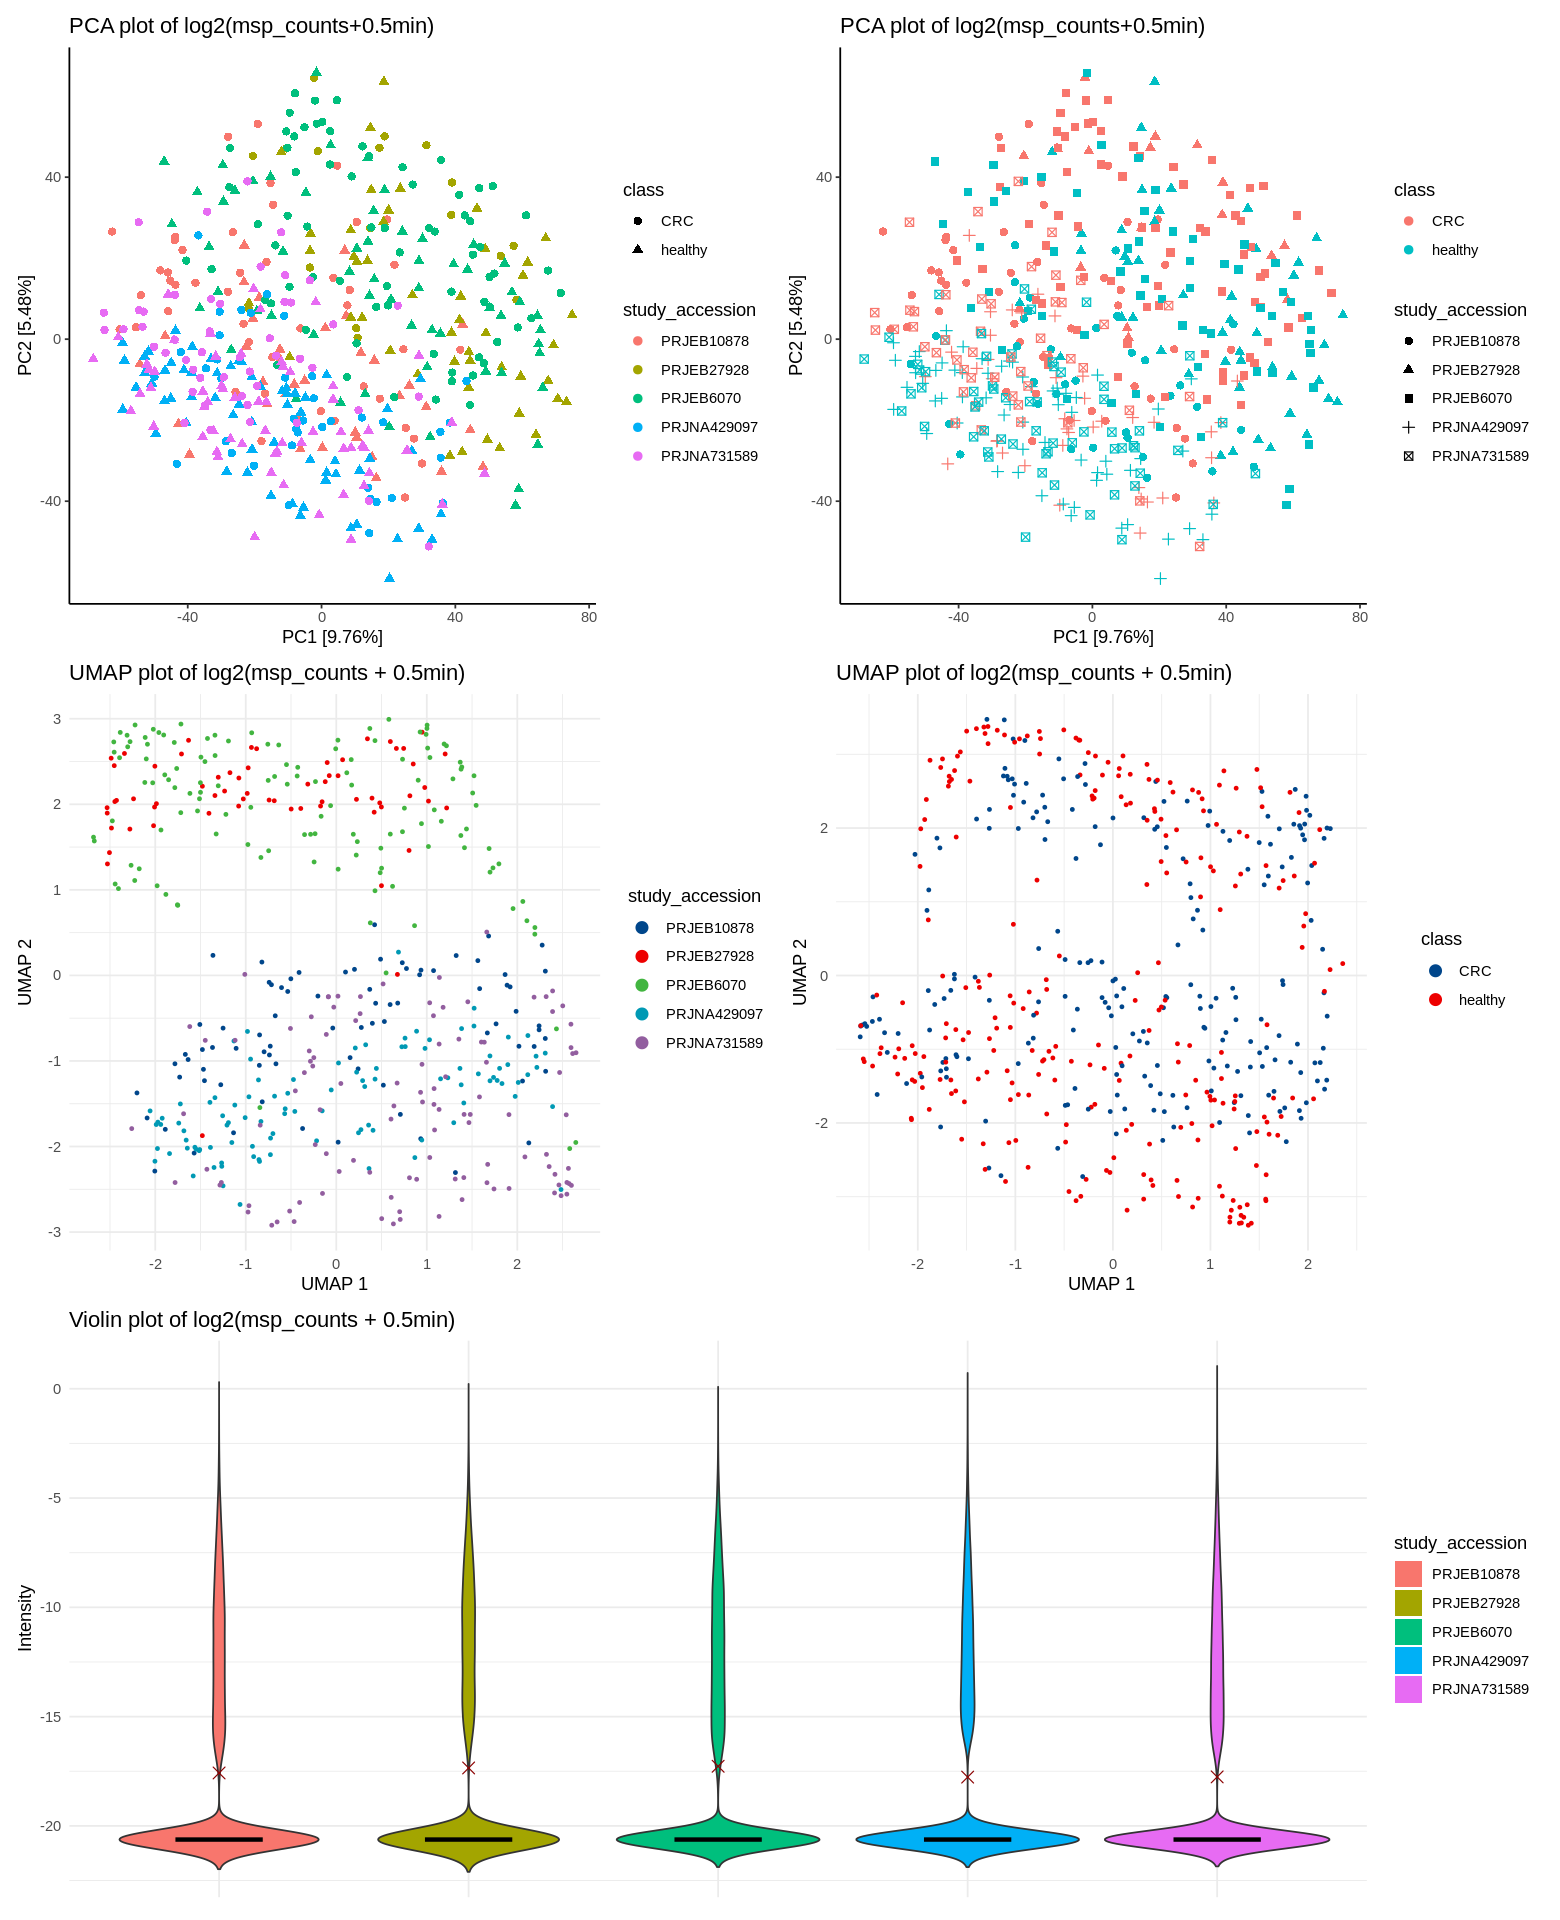

In [14]:
layout <- (pca_plot_study | pca_plot_class) /
          (umap_plot_study | umap_plot_class) /
          violin_plots

options(repr.plot.width=13, repr.plot.height=16)
layout

## QU norm

In [15]:
msp_counts[is.na(msp_counts)] <- 0

cat('Before normalization, shape:', dim(msp_counts), '\n')
cat('% of zeros:', sum(msp_counts == 0) * 100 / (nrow(msp_counts) * ncol(msp_counts)), '\n')

quantileExpressed <- apply(msp_counts, 2, function(x) { quantile(x[x > 0], 0.75) })
msp_counts_norm <- t(t(msp_counts) / quantileExpressed)

cat('After normalization, shape:', dim(msp_counts_norm), '\n')
cat('% of zeros:', sum(msp_counts_norm == 0) * 100/ (nrow(msp_counts_norm) * ncol(msp_counts_norm)), '\n')


Before normalization, shape: 845 485 


% of zeros: 65.57726 
After normalization, shape: 845 485 
% of zeros: 65.57726 


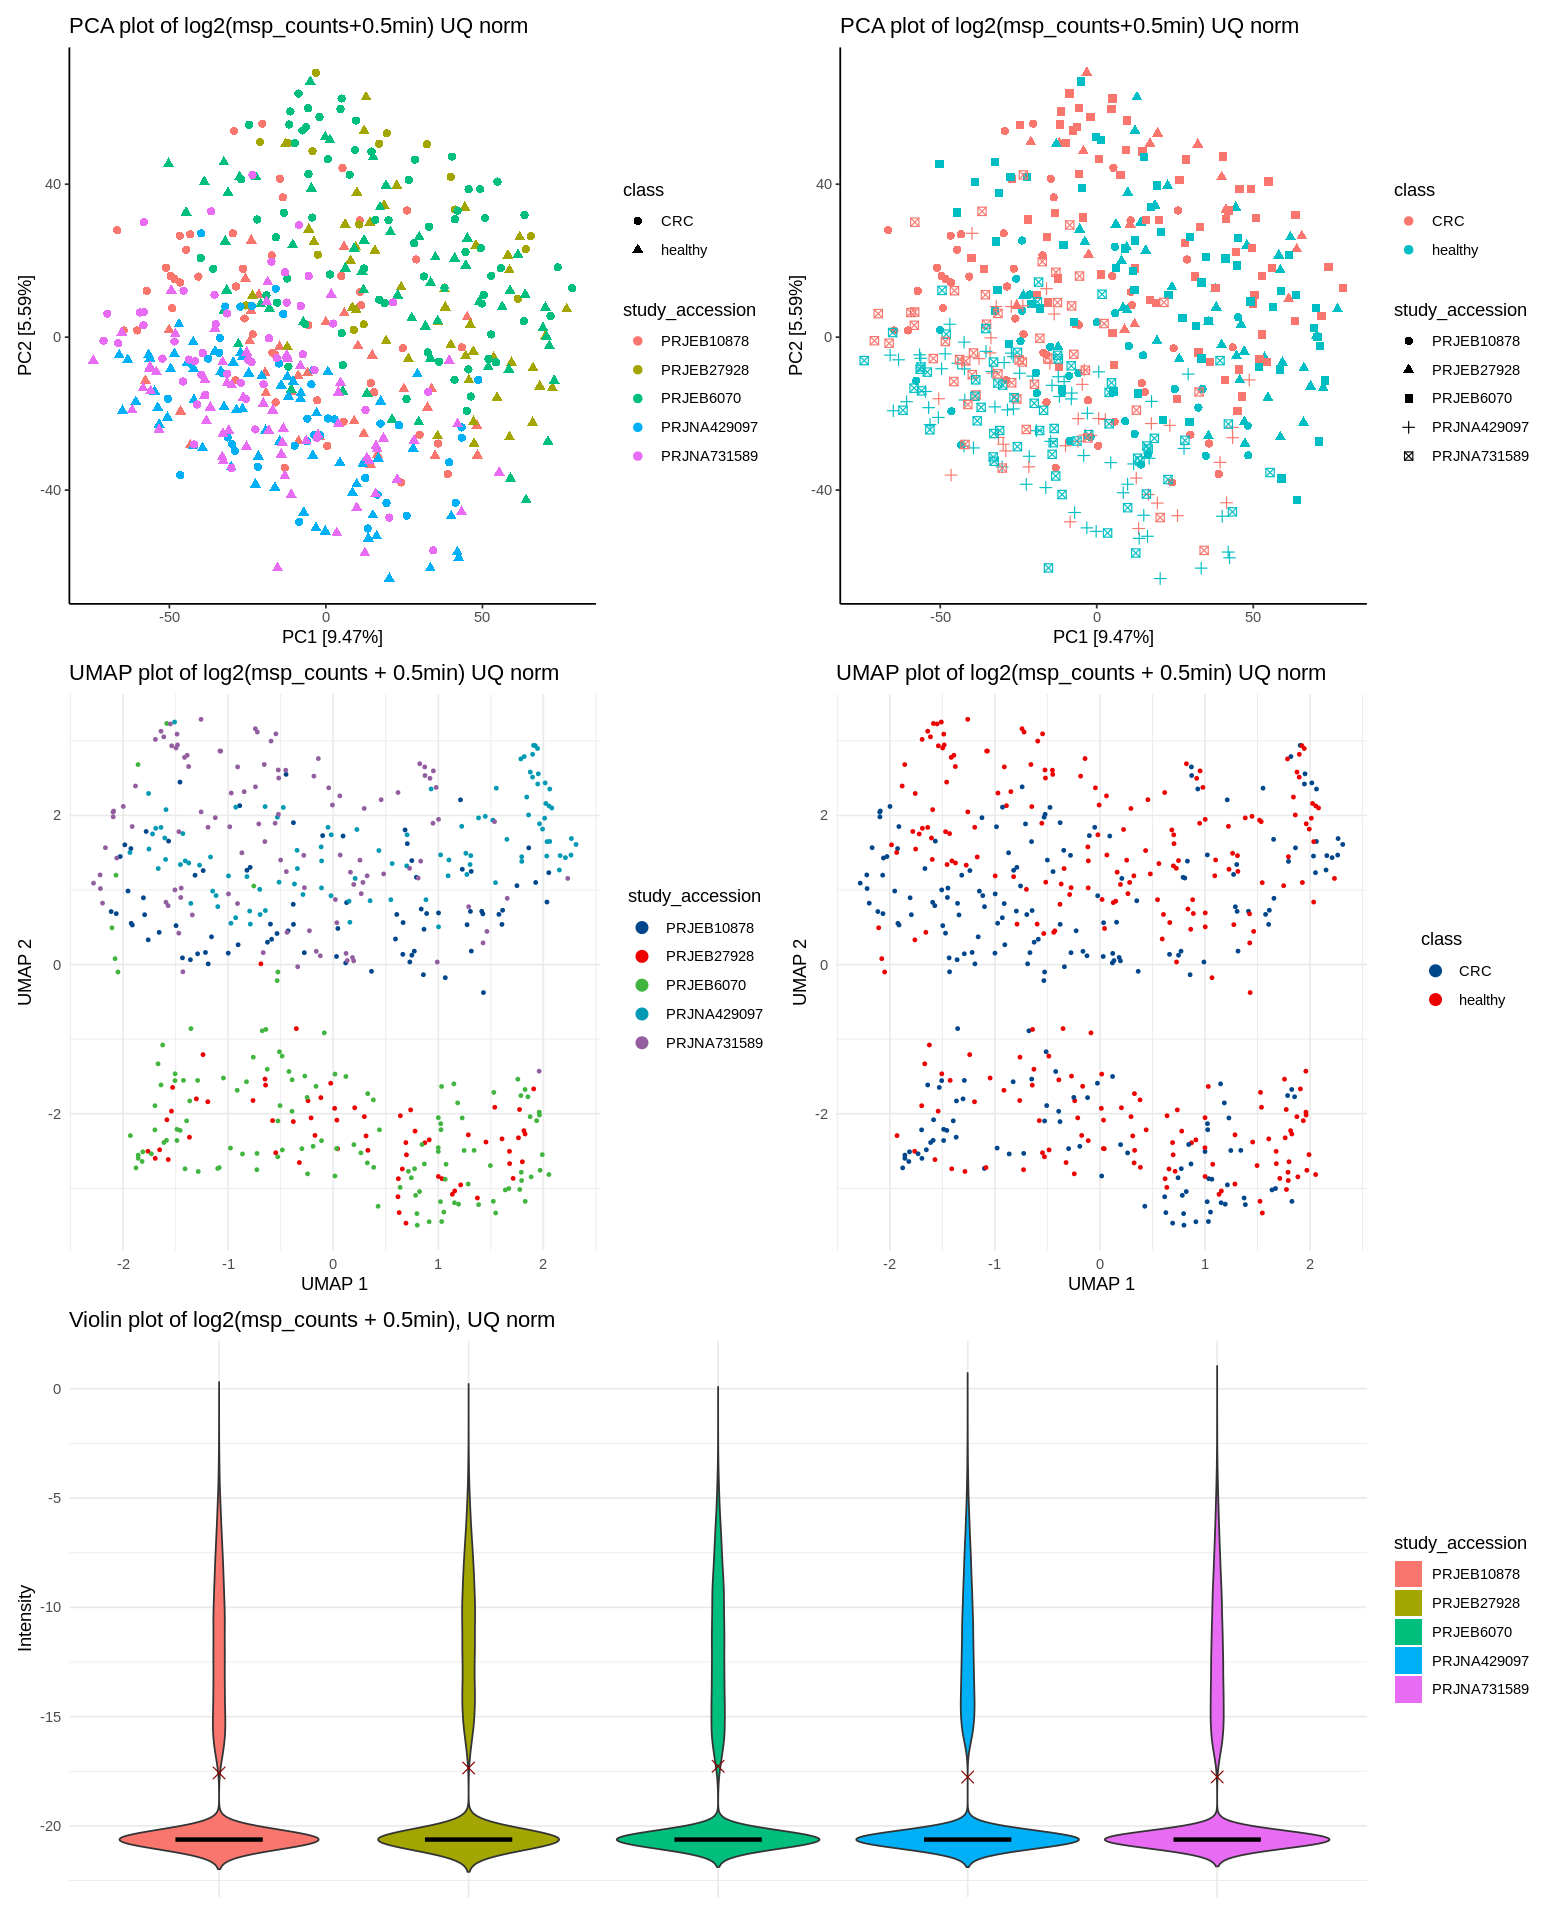

In [16]:
msp_counts_norm <- msp_counts_norm %>% as.data.frame()
logmin_msp_counts_norm <- log2(msp_counts_norm + min(msp_counts_norm[msp_counts_norm > 0])/2)

pca_plot_study <- pca_plot(
    logmin_msp_counts_norm, metadata, 
    title = "PCA plot of log2(msp_counts+0.5min) UQ norm",
    quantitative_col_name = 'sample',
    col_col = "study_accession", shape_col = "class")

pca_plot_class <- pca_plot(
    logmin_msp_counts_norm, metadata, 
    title = "PCA plot of log2(msp_counts+0.5min) UQ norm",
    quantitative_col_name = 'sample',
    shape_col = "study_accession", col_col = "class")

umap_plot_study <- umap_plot(
    logmin_msp_counts_norm, metadata, 
    title = "UMAP plot of log2(msp_counts + 0.5min) UQ norm", color_column = "study_accession")
umap_plot_class <- umap_plot(
    logmin_msp_counts_norm, metadata, 
    title = "UMAP plot of log2(msp_counts + 0.5min) UQ norm", color_column = "class")

boxplot_results <- boxplot_plot(
    logmin_msp_counts_norm, metadata,
    quantitativeColumnName = 'sample', color_col = "study_accession",
    title = "Boxplot of merged MSPs, log2(msp_counts) with NA, UQ norm")

violin_plots <- boxplot_plot_groupped(logmin_msp_counts, metadata,
    title = paste("Violin plot of log2(msp_counts + 0.5min), UQ norm"),
    quantitativeColumnName = "sample",
    color_col = "study_accession", remove_xnames = T)

layout <- (pca_plot_study | pca_plot_class) /
          (umap_plot_study | umap_plot_class) /
          violin_plots

options(repr.plot.width=13, repr.plot.height=16)
layout


No id variables; using all as measure variables

Warning message:
“Removed 268752 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 268752 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 268752 rows containing non-finite values (`stat_density()`).”


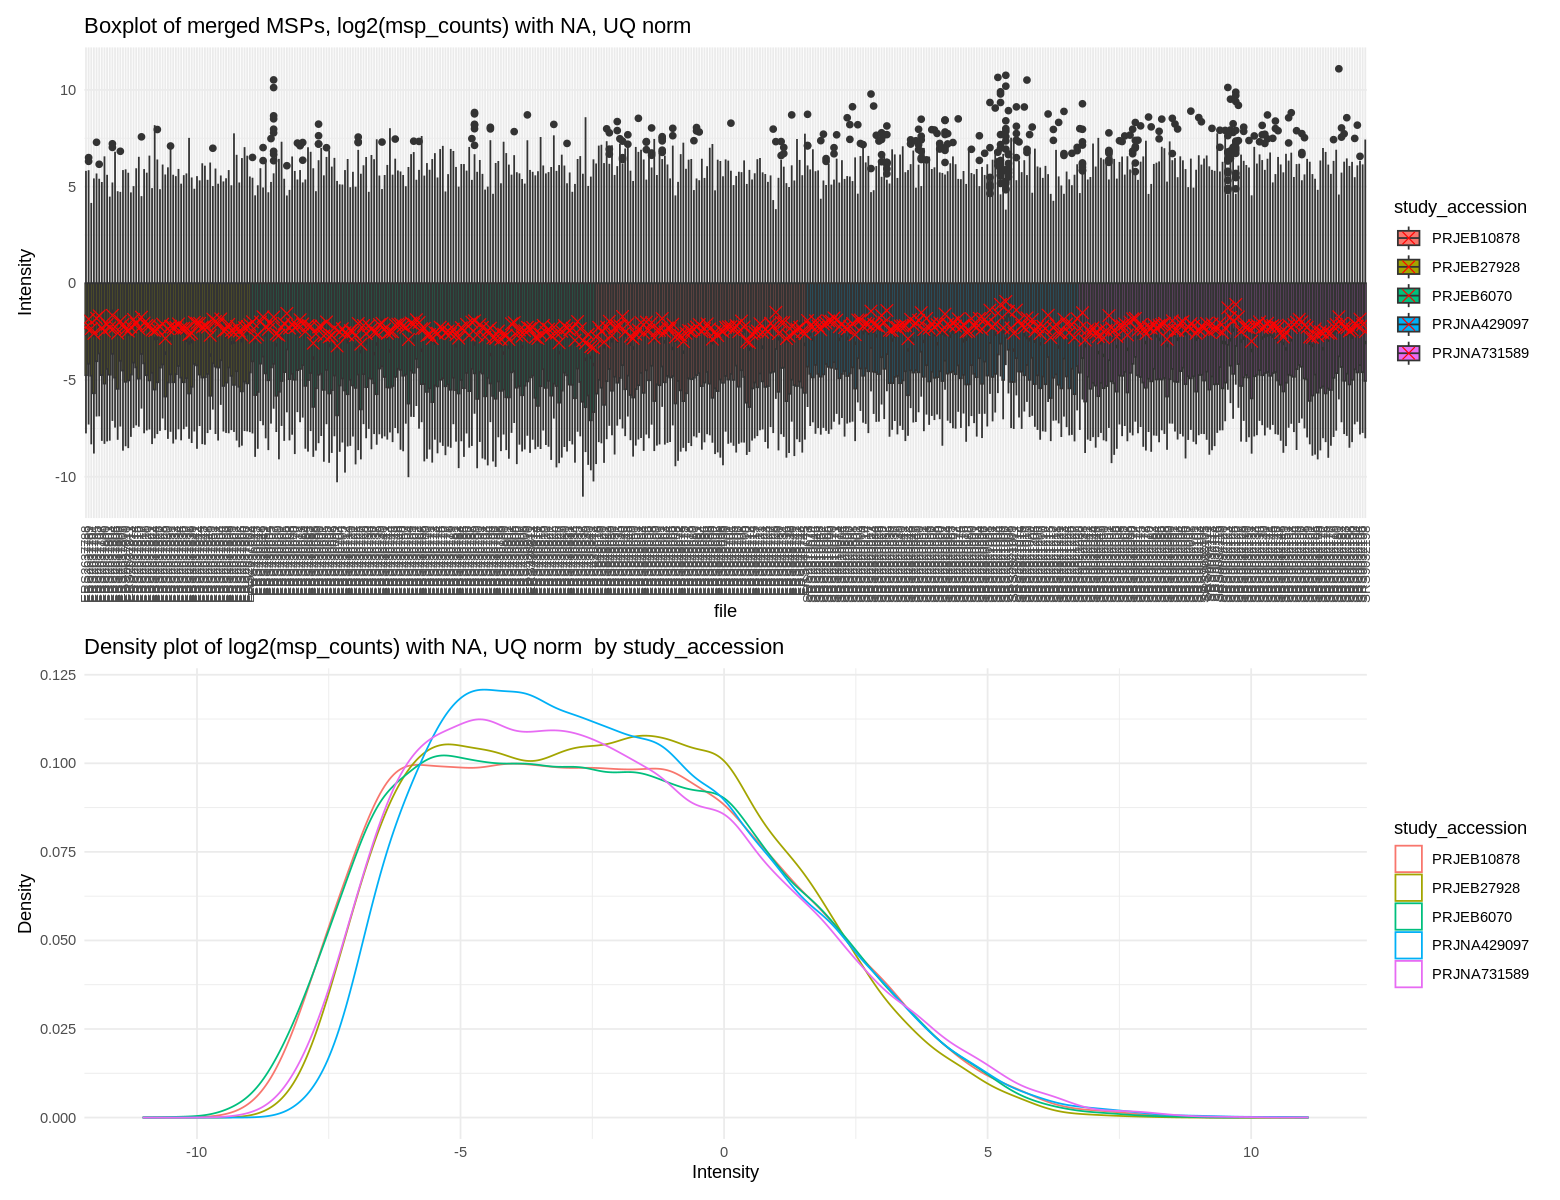

In [17]:
msp_counts_norm <- msp_counts_norm %>% as.data.frame()
logmin_msp_counts_norm <- log2(msp_counts_norm + min(msp_counts_norm[msp_counts_norm > 0])/2)

# replace 0 with NA
msp_counts_norm[msp_counts_norm == 0] <- NA
logmin_msp_counts_norm <- log2(msp_counts_norm)

boxplot_results <- boxplot_plot(
    logmin_msp_counts_norm, metadata,
    quantitativeColumnName = 'sample', color_col = "study_accession",
    title = "Boxplot of merged MSPs, log2(msp_counts) with NA, UQ norm")

density_plot <- plotIntensityDensity(
    logmin_msp_counts_norm, metadata, 
    quantitativeColumnName = 'sample', colorColumnName = 'study_accession',
    title = "Density plot of log2(msp_counts) with NA, UQ norm")


layout <-
          boxplot_results /
          density_plot

options(repr.plot.width=13, repr.plot.height=10)
layout


In [18]:
# return 0 
msp_counts_norm[is.na(msp_counts_norm)] <- 0
msp_counts[is.na(msp_counts)] <- 0
logmin_msp_counts_norm <- log2(msp_counts_norm + min(msp_counts_norm[msp_counts_norm > 0])/2)

rownames(metadata) <- metadata$sample

for(center in unique(metadata$study_accession)){
    # select only samples from the center
    center_msp_counts <- msp_counts[, metadata[metadata$study_accession == center,]$sample]
    center_msp_counts_norm <- msp_counts_norm[, metadata[metadata$study_accession == center,]$sample]
    center_logmin_msp_counts_norm <- logmin_msp_counts_norm[, metadata[metadata$study_accession == center,]$sample]
    metadata_center <- metadata[metadata[metadata$study_accession == center,]$sample, ]

    # save then to the corresponding folder
    path_before <- paste0('/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/before/', center, '/')
    #check if the folder exists and create it if not
    if (!dir.exists(path_before)){
        dir.create(path_before)
    }
    write.table(rownames_to_column(center_msp_counts, 'MSP'), paste0(path_before, 'msp_counts_raw_5C.tsv'), sep = '\t', row.names = F)
    write.table(rownames_to_column(center_msp_counts_norm, 'MSP'), paste0(path_before, 'msp_counts_norm_5C.tsv'), sep = '\t', row.names = F)
    write.table(rownames_to_column(center_logmin_msp_counts_norm, 'MSP'), paste0(path_before, 'msp_counts_norm_logmin_5C.tsv'), sep = '\t', row.names = F)
    write.table(metadata_center, paste0(path_before, 'metadata_5C.tsv'), sep = '\t', row.names = F)
}

# save for the central analysis
write.table(msp_counts_norm %>% rownames_to_column('MSP'), 
    file = "/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/before/normalized_counts_5C.tsv", sep = "\t", quote = FALSE, row.names = F)
write.table(msp_counts %>% rownames_to_column('MSP'), 
    file = "/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/before/raw_counts_5C.tsv", sep = "\t", quote = FALSE, row.names = F)
write.table(logmin_msp_counts_norm %>% rownames_to_column('MSP'),
    file = "/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/before/logmin_normalized_counts_5C.tsv", sep = "\t", quote = FALSE, row.names = F)

# save metadata
write.table(metadata, file = "/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/before/metadata_5C.tsv", sep = "\t", quote = FALSE)

In [19]:
dim(logmin_msp_counts_norm)

[1] 845 485

# Batch effects correction

In [20]:
# zeros to NA
msp_counts_norm[is.na(msp_counts_norm)] <- 0

# arrane normalized data 
msp_counts_norm <- msp_counts_norm %>% as.data.frame()
msp_counts_norm <- msp_counts_norm[,metadata$sample]

In [21]:
metadata <- metadata %>%
    mutate(class = factor(class, levels = c("healthy", "CRC")))

In [22]:
# create design
design = model.matrix(~class, data = metadata)
colnames(design) <- c("Intercept", "CRC")
rownames(design) <- metadata$sample

# log2
logmin_msp_counts_norm <- log2(msp_counts_norm + min(msp_counts_norm[msp_counts_norm > 0],na.rm = T)/2)
msp_norm_corrected <- limma::removeBatchEffect(logmin_msp_counts_norm, metadata$study_accession, design = design) %>% as.data.frame()


No id variables; using all as measure variables



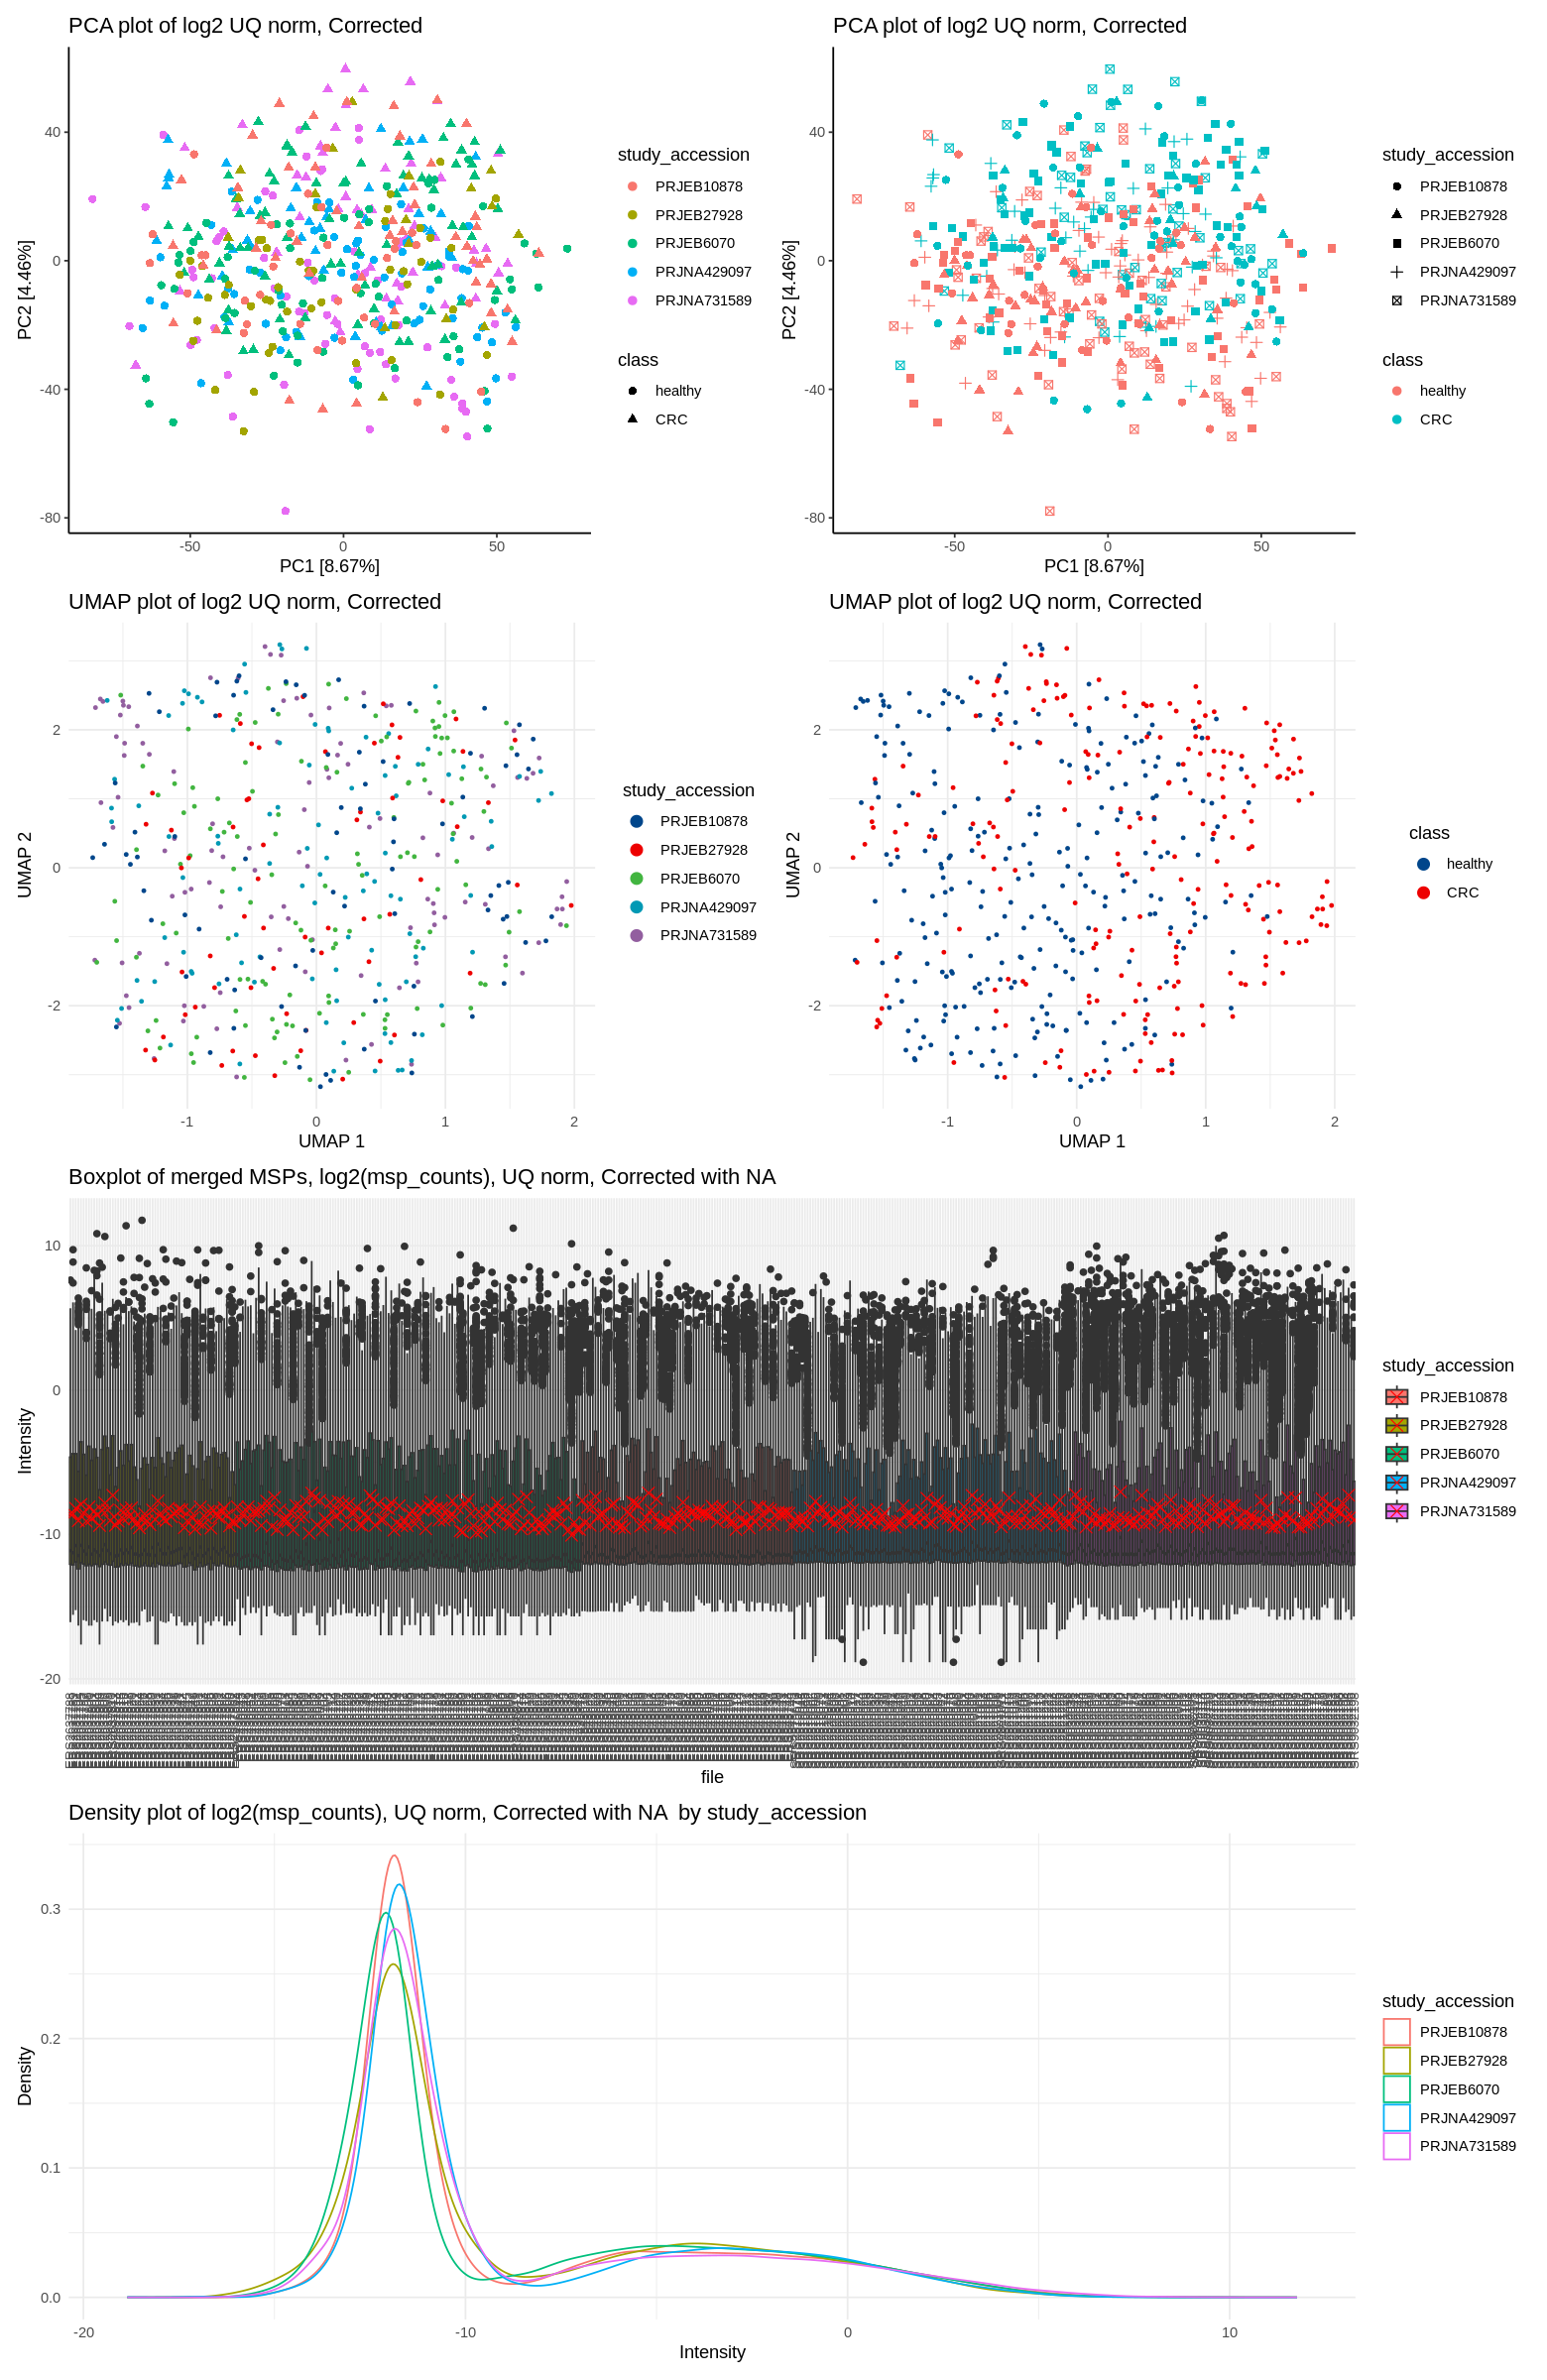

In [23]:
pca_plot_study <- pca_plot(
    msp_norm_corrected, metadata, 
    title = "PCA plot of log2 UQ norm, Corrected",
    quantitative_col_name = 'sample',
    col_col = "study_accession", shape_col = "class")

pca_plot_class <- pca_plot(
    msp_norm_corrected, metadata, 
    title = "PCA plot of log2 UQ norm, Corrected",
    quantitative_col_name = 'sample',
    shape_col = "study_accession", col_col = "class")

umap_plot_study <- umap_plot(
    msp_norm_corrected, metadata, 
    title = "UMAP plot of log2 UQ norm, Corrected", color_column = "study_accession")
umap_plot_class <- umap_plot(
    msp_norm_corrected, metadata, 
    title = "UMAP plot of log2 UQ norm, Corrected", color_column = "class")

# replace 0 with NA
# msp_norm_corrected[msp_norm_corrected == 0] <- NA

boxplot_results <- boxplot_plot(
    msp_norm_corrected, metadata,
    quantitativeColumnName = 'sample', color_col = "study_accession",
    title = "Boxplot of merged MSPs, log2(msp_counts), UQ norm, Corrected with NA")

density_plot <- plotIntensityDensity(
    msp_norm_corrected, metadata, 
    quantitativeColumnName = 'sample', colorColumnName = 'study_accession',
    title = "Density plot of log2(msp_counts), UQ norm, Corrected with NA")


layout <- (pca_plot_study | pca_plot_class) /
          (umap_plot_study | umap_plot_class) /
          boxplot_results /
          density_plot

options(repr.plot.width=13, repr.plot.height=20)
layout


In [24]:
msp_norm_corrected[is.na(msp_norm_corrected)] <- 0
design <- design %>% as.data.frame()

for(center in unique(metadata$study_accession)){
    design_center <- design[metadata[metadata$study_accession == center,]$sample, ]["CRC"]
    # save then to the corresponding folder
    path_after <- paste0('/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/after/', center, '/')
    path_before <- paste0('/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/before/', center, '/')
    #check if the folder exists and create it if not
    if (!dir.exists(path_after)){
        dir.create(path_after)
    }
    write.table(rownames_to_column(design_center, 'sample'), paste0(path_before, 'design_5C.tsv'), sep = '\t', row.names = F)
}

# save for the central analysis
write.table(msp_norm_corrected %>% rownames_to_column('MSP'), 
    file = "/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/after/normalized_logmin_counts_5centers_corrected_CENTRAL.tsv", sep = "\t", quote = FALSE, row.names = F)
# metadata
write.table(metadata, file = "/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/after/metadata_5C.tsv", sep = "\t", quote = FALSE, row.names = F)

In [25]:
dim(metadata)

[1] 485  34